##### Importando Bibliotecas

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.ml.fpm import FPGrowth
from pyspark.sql.functions import avg
from pyspark.sql.functions import collect_list, expr
from pyspark.sql.functions import col
import pyspark.sql.functions as F
import matplotlib.pyplot as plt
from pyspark.sql.functions import count
import pandas as pd
from config import user, password, host, port, database

##### Configurando conexão com o PostgreSQL

In [2]:
spark = SparkSession.builder \
    .appName('Conexão com PostgreSQL') \
    .config('spark.jars', 'postgresql-42.6.0.jar') \
    .config('spark.driver.extraClassPath', 'postgresql-42.6.0.jar') \
    .config('spark.executor.extraClassPath', 'postgresql-42.6.0.jar') \
    .getOrCreate()

In [3]:
url = f'jdbc:postgresql://{host}:{port}/{database}'
properties = {
    'user': user,
    'password': password,
    'driver': 'org.postgresql.Driver'
}

In [4]:
sql = "SELECT table_name FROM information_schema.tables WHERE table_schema = 'public'"

tabelas_df = spark.read.format('jdbc') \
    .option('url', url) \
    .option('query', sql) \
    .option('user', user) \
    .option('password', password) \
    .load()

tabelas = tabelas_df.select('table_name').rdd.flatMap(lambda x: x).collect()

##### Analisando informações do banco de Dados

In [5]:
for tabela in tabelas:
    df = spark.read.jdbc(url=url, table=tabela, properties=properties)
    total_registros = df.count()
    display(f'Total de registros na tabela: {tabela}', total_registros)

'Total de registros na tabela: categorias'

30

'Total de registros na tabela: subcategorias'

132

'Total de registros na tabela: produtos'

2700000

'Total de registros na tabela: clientes'

45000

'Total de registros na tabela: pedidos'

3000003

'Total de registros na tabela: itenspedido'

1202348

'Total de registros na tabela: carrinhoscompras'

82250

'Total de registros na tabela: itenscarrinho'

82362

'Total de registros na tabela: avaliacoesprodutos'

14349

'Total de registros na tabela: informacoespagamento'

274999

##### Carregando dados de tabelas relacionadas usando o SparkSession e JDBC

In [6]:
spark = SparkSession.builder.getOrCreate()

df_carrinhos_compras = spark.read.format('jdbc').option('url', url) \
    .option('dbtable', 'carrinhoscompras') \
    .option('user', user) \
    .option('password', password) \
    .load()

df_itens_carrinho = spark.read.format('jdbc').option('url', url) \
    .option('dbtable', 'itenscarrinho') \
    .option('user', user) \
    .option('password', password) \
    .load()

df_produtos = spark.read.format('jdbc').option('url', url) \
    .option('query', 'SELECT * FROM produtos') \
    .option('user', user) \
    .option('password', password) \
    .load()

df_categorias = spark.read.format('jdbc').option('url', url) \
    .option('query', 'SELECT * FROM categorias') \
    .option('user', user) \
    .option('password', password) \
    .load()

df_subcategorias = spark.read.format('jdbc').option('url', url) \
    .option('query', 'SELECT * FROM subcategorias') \
    .option('user', user) \
    .option('password', password) \
    .load()

##### Fazendo Regras de Associação 

In [7]:
df_itens_carrinho = df_itens_carrinho.selectExpr('idcarrinho', 'idproduto') \
.distinct()

itens_por_carrinho = df_itens_carrinho.groupBy('idcarrinho').agg(collect_list('idproduto').alias('itens'))

In [8]:
fp_growth = FPGrowth(itemsCol='itens', minSupport=0.001, minConfidence=0.001)
modelo = fp_growth.fit(itens_por_carrinho)
regras_assoc = modelo.associationRules
regras_assoc.show()

+----------+----------+--------------------+------------------+--------------------+
|antecedent|consequent|          confidence|              lift|             support|
+----------+----------+--------------------+------------------+--------------------+
|      [14]|       [5]|0.030693444486547934|0.6169168863434172|0.001557183228559...|
|      [14]|      [31]| 0.03902993558165972|0.7728283818618933|0.001980121883230...|
|      [14]|       [4]|0.028419856006062904|  0.56923975736133|0.001441836322740...|
|      [14]|      [10]|0.028798787419477074|0.5808555739429775|0.001461060807043...|
|      [14]|      [28]|0.034861690034103825|0.6929310395506224|0.001768652555895188|
|      [14]|      [17]|0.030693444486547934|0.6224486946809995|0.001557183228559...|
|      [14]|       [2]|0.029556650246305417|0.5924656169025314|0.001499509775650...|
|      [14]|      [18]| 0.03334596438044714|0.6663684322618973|0.001691754618682...|
|      [14]|      [13]|0.034103827207275485|0.6815131693587587|0.

In [9]:
regras_assoc = regras_assoc.join(df_produtos, col('antecedent')[0] == col('ID'), 'left').select(regras_assoc.columns + [col('preco').alias('preco_antecedent')]).drop("ID")
regras_assoc = regras_assoc.join(df_produtos, col('consequent')[0] == col('ID'), 'left').select(regras_assoc.columns + [col('preco').alias('preco_consequent')]).drop("ID")

regras_assoc.show()

+----------+----------+--------------------+------------------+--------------------+----------------+----------------+
|antecedent|consequent|          confidence|              lift|             support|preco_antecedent|preco_consequent|
+----------+----------+--------------------+------------------+--------------------+----------------+----------------+
|      [14]|      [26]|0.029177718832891247|0.5608785663453452|0.001480285291347...|          199.99|           59.99|
|      [14]|      [28]|0.034861690034103825|0.6929310395506224|0.001768652555895188|          199.99|           29.99|
|      [14]|      [31]| 0.03902993558165972|0.7728283818618933|0.001980121883230...|          199.99|           99.99|
|      [14]|      [13]|0.034103827207275485|0.6815131693587587|0.001730203587288771|          199.99|           19.99|
|      [14]|      [22]| 0.03372489579386131|  0.67497803174655|0.001710979102985...|          199.99|           29.99|
|      [14]|       [3]|0.027283061765820387|0.53

In [10]:
regra_lift = regras_assoc.filter(col('lift') > 0.8)

regra_lift.show()

+----------+----------+--------------------+------------------+--------------------+----------------+----------------+
|antecedent|consequent|          confidence|              lift|             support|preco_antecedent|preco_consequent|
+----------+----------+--------------------+------------------+--------------------+----------------+----------------+
|       [1]|      [27]| 0.04043126684636118|0.8082679506330398|0.002018570851836...|           49.99|           99.99|
|      [22]|      [28]|0.041554444016929586|0.8259600742944694|0.002076244304746525|           29.99|           29.99|
|      [22]|      [31]|0.041554444016929586|0.8228159552450043|0.002076244304746525|           29.99|           99.99|
|      [27]|       [1]| 0.04035357417371253|0.8082679506330399|0.002018570851836...|           99.99|           49.99|
|      [13]|      [12]|0.040338071456012294|0.8033175585480059|0.002018570851836...|           19.99|           29.99|
|       [6]|      [12]| 0.04060324825986079| 0.8

##### Analisando Informações do BD

In [11]:
df_join = df_produtos.join(df_categorias, df_produtos['idcategoria'] == df_categorias['id']).select(df_produtos['*'], df_categorias['nome'].alias('nome_categoria'))
df_join.show()

+-------+------------------+--------------------+-----+-----------+--------------+--------------+
|     id|              nome|           descricao|preco|idcategoria|idsubcategoria|nome_categoria|
+-------+------------------+--------------------+-----+-----------+--------------+--------------+
|2094360|     Camisa Xadrez|Camisa xadrez mas...|39.99|          1|             2|        Roupas|
|2094361|     Camisa Xadrez|Camisa xadrez mas...|39.99|          1|             2|        Roupas|
|2094363|     Camisa Xadrez|Camisa xadrez mas...|39.99|          1|             2|        Roupas|
|2094365|  Blazer Masculino|Blazer masculino ...|79.99|          1|             8|        Roupas|
|2094369| Camiseta Listrada|Camiseta listrada...|29.99|          1|             5|        Roupas|
|2094370|    Blusa de Tricô|Blusa de tricô fe...|49.99|          1|             6|        Roupas|
|2094374|    Vestido Floral|Vestido estampado...|59.99|          1|             1|        Roupas|
|2094375| Camiseta L

In [12]:
media_categoria = df_join.groupBy('nome_categoria').agg(avg('preco').alias('media_preco'))

media_categoria.show()

+--------------+-----------+
|nome_categoria|media_preco|
+--------------+-----------+
|        Roupas|  51.240572|
|   Eletrônicos| 416.776332|
|        Livros|  23.731674|
|    Tecnologia|  86.026156|
|      Calçados|  74.289186|
+--------------+-----------+



acima fizemos o calculo da média de preço por categoria

In [13]:
df_join = df_produtos.join(df_subcategorias, df_produtos['idsubcategoria'] == df_subcategorias['id'], 'inner') \
                     .join(df_categorias, df_produtos['idcategoria'] == df_categorias['id'], 'inner') \
                     .select(df_categorias['nome'].alias('nome_categoria'), df_subcategorias['nome'].alias('nome_subcategoria')) \
                     .where((df_produtos['idcategoria'] == df_categorias['id']) & (df_produtos['idsubcategoria'] == df_subcategorias['id']))

df_join.show()

+--------------+-----------------+
|nome_categoria|nome_subcategoria|
+--------------+-----------------+
|        Roupas|         Vestidos|
|        Roupas|         Vestidos|
|        Roupas|         Vestidos|
|        Roupas|         Vestidos|
|        Roupas|         Vestidos|
|        Roupas|         Vestidos|
|        Roupas|         Vestidos|
|        Roupas|         Vestidos|
|        Roupas|         Vestidos|
|        Roupas|         Vestidos|
|        Roupas|         Vestidos|
|        Roupas|         Vestidos|
|        Roupas|         Vestidos|
|        Roupas|         Vestidos|
|        Roupas|         Vestidos|
|        Roupas|         Vestidos|
|        Roupas|         Vestidos|
|        Roupas|         Vestidos|
|        Roupas|         Vestidos|
|        Roupas|         Vestidos|
+--------------+-----------------+
only showing top 20 rows



In [14]:
contagem_categorias = df_join.groupBy('nome_categoria') \
                               .agg(count('*').alias('contagem')) \
                               .orderBy('contagem', ascending=False)

contagem_categorias.show()

+--------------+--------+
|nome_categoria|contagem|
+--------------+--------+
|        Roupas|  697545|
|   Eletrônicos|  609503|
|      Calçados|  608578|
|    Tecnologia|  435784|
|        Livros|  348590|
+--------------+--------+



In [15]:
contagem_subcategorias = df_join.groupBy('nome_subcategoria') \
                               .agg(count('*').alias('contagem')) \
                               .orderBy('contagem', ascending=False)

contagem_subcategorias.show()

+-----------------+--------+
|nome_subcategoria|contagem|
+-----------------+--------+
|         Vestidos|  610551|
|          Camisas|  521832|
|           Calças|  435637|
|            Saias|  435527|
|           Blusas|  348323|
|            Tênis|  174169|
|        Sandálias|   87021|
|          Sapatos|   86940|
+-----------------+--------+



fizemos a contagem das categorias, subcategorias e quantidade de produtos por categoria 

In [16]:
limite_preco = 100.0

registros_acima_limite = df_produtos.join(df_categorias, df_produtos['idcategoria'] == df_categorias['id']) \
                                    .filter(df_produtos['preco'] > limite_preco)

contagem_por_categoria = registros_acima_limite.groupBy(df_categorias['nome'].alias('nome_categoria')).count()

contagem_por_categoria.show()

+--------------+------+
|nome_categoria| count|
+--------------+------+
|      Calçados| 87124|
|   Eletrônicos|436166|
|    Tecnologia| 87232|
+--------------+------+



fizemos acima um filtro para analisar quais categorias tem produtos com preço acima de 100

##### Visualizando Dados

In [17]:
df_join = df_produtos.join(df_categorias, df_produtos['idcategoria'] == df_categorias['id'], 'inner') \
                     .select(df_categorias['nome'].alias('nome_categoria'))

In [18]:
categoria_counts = df_join.groupBy('nome_categoria').count().orderBy('count', ascending=False)
categoria_counts = categoria_counts.toPandas()

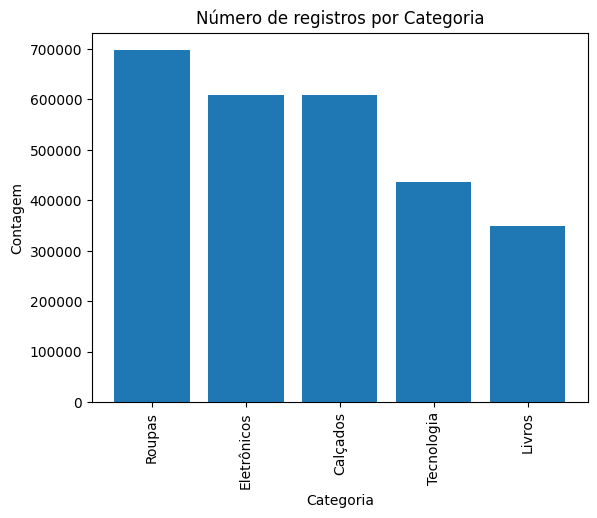

In [19]:
plt.bar(categoria_counts['nome_categoria'], categoria_counts['count'])
plt.xlabel('Categoria')
plt.ylabel('Contagem')
plt.title('Número de registros por Categoria')
plt.xticks(rotation=90)
plt.show()

acima vemos a quantidade de produtos vendidos por categoria

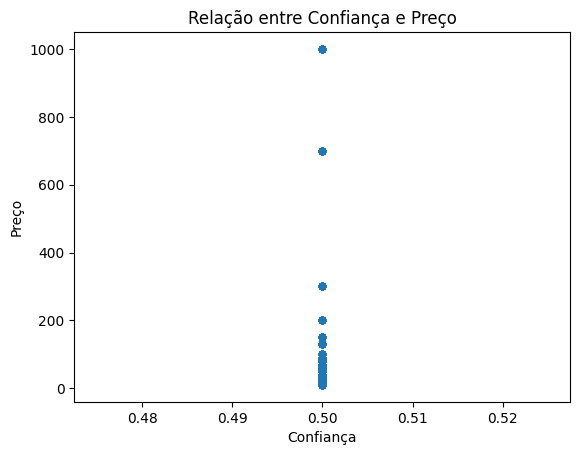

In [20]:
preco_confianca = df_produtos.select('preco', lit(0.5).alias('confianca')).toPandas()
preco_confianca.plot.scatter(x='confianca', y='preco')
plt.xlabel('Confiança')
plt.ylabel('Preço')
plt.title('Relação entre Confiança e Preço')
plt.show()

o scatter plot acima nos traz que no intervalo de confiança 0.50 temos uma grande quantidade de produtos com preço entre 50 e 300 reais e logo após temos alguns pontos discrepantes com preços de 700 e 1000 reais

In [21]:
confianca = regras_assoc.select(col('preco_antecedent').alias('preco'), regras_assoc['confidence'])

confianca.show()

+------+--------------------+
| preco|          confidence|
+------+--------------------+
|199.99|0.029177718832891247|
|199.99|0.034861690034103825|
|199.99| 0.03902993558165972|
|199.99|0.034103827207275485|
|199.99| 0.03372489579386131|
|199.99| 0.03372489579386131|
|199.99|0.027283061765820387|
|199.99|0.030693444486547934|
|199.99| 0.02804092459264873|
|199.99| 0.03220917014020462|
|199.99|   0.035240621447518|
|199.99|0.030693444486547934|
|199.99|0.028419856006062904|
|199.99|0.031072375899962108|
|199.99|0.028798787419477074|
|199.99| 0.03220917014020462|
|199.99|0.030314513073133764|
|199.99| 0.03372489579386131|
|199.99| 0.03145130731337628|
|199.99|0.029556650246305417|
+------+--------------------+
only showing top 20 rows



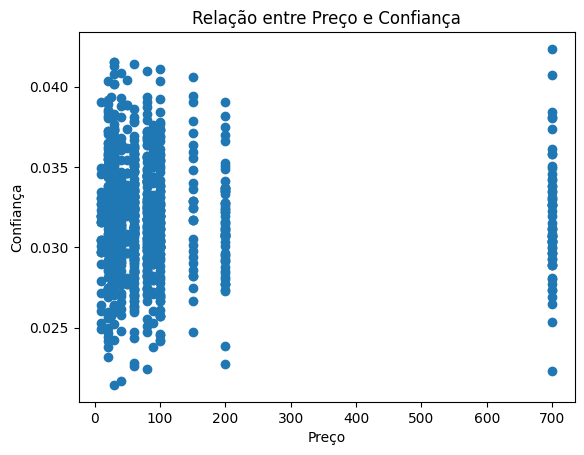

In [22]:
confianca_pd = confianca.toPandas()

plt.scatter(confianca_pd['preco'], confianca_pd['confidence'])
plt.xlabel('Preço')
plt.ylabel('Confiança')
plt.title('Relação entre Preço e Confiança')
plt.show()

O gráfico mostra uma relação entre o preço e a confiança dos produtos. A maioria dos produtos com preços entre 0 e 200 tem confiança baixa, mas há um ponto isolado em torno de 700 com confiança alta. Em geral, quanto maior o preço, maior a confiança, exceto por esse caso excepcional.